## Creating TFRecords for Image Data at Scale
In this lab you will create TFRecords for an image classification dataset. In this lab you will develop an Apache Beam pipeline that creates TFRecords for image data, and submit a Dataflow job to create these TFRecords at scale.

Learning Objectives:
* Learn how to serialize image data to TFRecords at scale
* Learn how to extend `beam.DoFn` for creating `tf.Example` protos.
* Learn how to use `beam.io.tfrecordio.WriteToTFRecord` to write TFRecords from a Beam pipeline
* Learn how to deploy an Apache Beam pipeline to Dataflow

#### Setup

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT + "-flowers"
REGION = "us-central1"
CLASSES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
DATASET_FILE = f"gs://{BUCKET}/flowers.csv"

%env PROJECT={PROJECT}
%env BUCKET={BUCKET}
%env REGION={REGION}
%env DATASET_FILE={DATASET_FILE}

env: PROJECT=kylesteckler-demo
env: BUCKET=kylesteckler-demo-flowers
env: REGION=us-central1
env: DATASET_FILE=gs://kylesteckler-demo-flowers/flowers.csv


In this lab we will be using GCS to store the data. Run the following cell to create this bucket.

In [3]:
%%bash
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
  echo -e "Bucket gs://${BUCKET} already exists."
    
else
   echo "Creating a new GCS bucket."
   gsutil mb -l ${REGION} gs://${BUCKET}
   echo -e "\nHere are your current buckets:"
   gsutil ls
fi

Bucket gs://kylesteckler-demo-flowers already exists.


Copy the dataset CSV file to your GCS bucket.

In [4]:
!gsutil cp ../dataset_import_files/flowers.csv {DATASET_FILE}

Copying file://../dataset_import_files/flowers.csv [Content-Type=text/csv]...
/ [1 files][260.0 KiB/260.0 KiB]                                                
Operation completed over 1 objects/260.0 KiB.                                    


#### Look at Dataset Import File

In [5]:
examples = pd.read_csv(DATASET_FILE)
examples.columns = ["imageUri", "label"]
examples.head()

,imageUri,label
0,gs://cloud-ml-data/img/flower_photos/dandelion...,dandelion
1,gs://cloud-ml-data/img/flower_photos/dandelion...,dandelion
2,gs://cloud-ml-data/img/flower_photos/dandelion...,dandelion
3,gs://cloud-ml-data/img/flower_photos/daisy/406...,daisy
4,gs://cloud-ml-data/img/flower_photos/roses/742...,roses


As you can see, this Image Classification dataset is represented as a CSV file with pattern `Image URI, Label`. The Image URIs point to jpeg images, stored in a publically available GCS bucket. This file will be used as input to a Beam pipeline that creates `.tfrecord` files of the data.

#### Look at one example

2022-06-09 15:14:00.092820: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


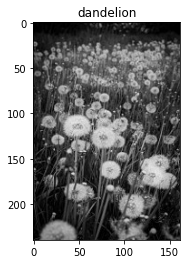

In [6]:
single_example = examples.iloc[0]
img = tf.io.decode_jpeg(tf.io.read_file(single_example.imageUri))
plt.imshow(img)
plt.title(single_example.label)
plt.show()

### Use Apache Beam and Dataflow to Create TFRecords at scale
With image data, it is common to have very large datasets. In these situations converting images to TFRecords locally isn't feasible. We can leverage the massive scalability of Cloud Dataflow to do this for us.

Dataflow is an execution engine for Apache Beam, so we need to create a Beam pipeline to read from a CSV file and serialize the entire dataset to TFRecords. 

#### Apache Beam Pipeline
This Apache Beam pipeline will do the following
* Read in rows from a CSV file formatted as `imageURI, label`
* Create TF Examples with a custom `beam.DoFn`
* Randomly split the data into train and validation with `beam.Partition`
* Serialize Examples to TFRecords
* Write data out to GCS with `beam.io.tfrecordio.WriteToTFRecord`

In [7]:
%%writefile create_tfrecords.py

import apache_beam as beam
from apache_beam.options.pipeline_options import (
    GoogleCloudOptions, 
    PipelineOptions, 
    StandardOptions, 
    SetupOptions
)

from apache_beam.runners import DataflowRunner, DirectRunner
import argparse
import random 

import tensorflow as tf
import typing

# Schema of CSV file
class CSVRow(typing.NamedTuple):
    image_uri: str
    label: str

# DoFn to transform CSV rows to PCollection with schema
class ParseCsv(beam.DoFn):
    def process(self, element):
        image_uri, label = element.split(',')
        yield CSVRow(
            image_uri = image_uri,
            label = label
        )

# TFRecord Helper Functions
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _image_feature(value):
    """Returns a bytes_list from an image."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )

# DoFn to create TF Example's
class CreateTFExample(beam.DoFn):
    def process(self, element):
        CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
        img = tf.io.decode_jpeg(tf.io.read_file(element.image_uri))
        
        feature = {
            "image": _image_feature(img), 
            "label": _int64_feature(CLASSES.index(element.label)),
        }
        
        yield tf.train.Example(features=tf.train.Features(feature=feature))
        
def partition_fn(example, num_partitions, train_percent):
    if random.random() < train_percent:
        return 0
    return 1
    
# Function to run the Beam pipeline
def run():
    parser = argparse.ArgumentParser(description='Image Data to TFRecords')

    # Google Cloud options
    parser.add_argument('--project',required=True, help='Specify Google Cloud project')
    parser.add_argument('--region', required=True, help='Specify Google Cloud region')
    parser.add_argument('--staging_location', required=True, help='Specify Cloud Storage bucket for staging')
    parser.add_argument('--runner', required=True, help='Specify Apache Beam Runner')
    parser.add_argument('--job_name', required=True, help='Job name for Dataflow Runner')

    # Pipeline-specific options
    parser.add_argument('--dataset_file', required=True, help='GCS path to input CSV')
    parser.add_argument('--output_dir', required=True, help='GCS output directory')
    parser.add_argument('--train_percent', required=True, help='Percentage of training data')

    
    opts, pipeline_opts = parser.parse_known_args()

    # Setting up the Beam pipeline options.
    options = PipelineOptions(pipeline_opts)

    DATASET_FILE = opts.dataset_file
    OUTPUT_DIR = opts.output_dir
    TRAIN_PERCENT = float(opts.train_percent)
    
    # Set standard pipeline options.
    options.view_as(StandardOptions).streaming = False
    options.view_as(StandardOptions).runner = opts.runner
    options.view_as(SetupOptions).save_main_session = True

    # Set Google Cloud specific options.
    google_cloud_options = options.view_as(GoogleCloudOptions)
    google_cloud_options.project = opts.project
    google_cloud_options.job_name = opts.job_name
    google_cloud_options.staging_location = opts.staging_location
    google_cloud_options.region = opts.region

    
    # Instaniate pipeline
    if opts.runner=='DataflowRunner':
        p = beam.Pipeline(DataflowRunner(), options=options)
    else:
        p = beam.Pipeline(DirectRunner(), options=options)
        
    rows = ( p | "Read CSV" >> beam.io.ReadFromText(DATASET_FILE)
               | "Parse CSV" >> beam.ParDo(ParseCsv()))
    
    train, val = ( rows 
                   | "Create TF Examples" >> beam.ParDo(CreateTFExample()) 
                   | "Split Data" >> beam.Partition(partition_fn, 2, train_percent=TRAIN_PERCENT))
    
    
    
    write_train = ( train 
                       | "Serialize Training Examples" >> beam.Map(lambda x: x.SerializeToString()) 
                       | "Write Train" >> beam.io.tfrecordio.WriteToTFRecord(
                           f"{OUTPUT_DIR}/train.tfrecord", num_shards=10
                       )
                  )
    write_val = ( val 
                       | "Serialize Validation Examples" >> beam.Map(lambda x: x.SerializeToString()) 
                       | "Write Validation" >> beam.io.tfrecordio.WriteToTFRecord(
                           f"{OUTPUT_DIR}/eval.tfrecord", num_shards=3
                       )
                )
    
    # Run pipeline
    p.run()
    
if __name__ == '__main__':
    run()

Writing create_tfrecords.py


### A deeper look at this pipeline

#### Apache Beam Core Concepts
`Pcollection`: An immutable collections of values representing data elements.

`PTransform`: Represents a data processing operation, or a step, in your pipeline.

`ParDo`: A transform for generic parallel processing. A `ParDo` transform considers each element in the input `PCollection`, performs some processing function on that element, and emits elements to an output `PCollection`. The processing function passed to ParDo is a `DoFn` object.

`DoFn`: These are what define your pipeline's exact data processing tasks. To create a custom processing task, create a `DoFn` subclass (e.g. `class MyCustomProcessingTask(beam.DoFn)`) and write a method `def process(self, element):` where you provide the actual processing logic. You don't need to manually extract the elements from the input collection; the Beam SDKs handle that for you. Your `process` method should accept an argument `element`, which is the input element, and return an interable with its output values. You can accomplish this by emitting individual elements with `yield` statements. 

#### Image data to TFRecord Pipeline
1) `beam.io.ReadFromText`: A `PTransform` for reading text files into `str` elements. It returns one element for each line the file. With the input CSV file for our image dataset, it will return a string element `"{imageUri}, {label}"` for each row in the CSV.

2) `beam.ParDo(ParseCsv())`: A `PTransform` that applies `ParseCsv` (a custom `DoFn`), to each string element in the output `PCollection` from `beam.io.ReadFromText`. The `process` method for `ParseCsv` simply uses the `str.split()` method to split each row and return a `NamedTuple` of the image URI and label for each example in the dataset.

3) `beam.ParDo(CreateTFExample())`. A `PTransform` that applies `CreateTFExample()` (a custom `DoFn`), to each element in the output `PCollection` from `beam.ParDo(ParseCsv())`. The `process` method for `CreateTFExample()` first reads and decodes the image from the image URI with `tf.io.read_file` and `tf.io.decode_jpeg`, creates a feature dictionary with our TFRecord helper functions, and returns a `tf.train.Example` proto.

4) `beam.Partition(partition_fn, 2, train_percent)`: A `PTransform` that seperates elements in a collection into multiple output collections. The partitioning function provided contains the logic that determines how to seperate the elements into each resulting partition. In our pipeline, our custom `partition_fn` simply splits the input collection into 2 partitions, a training partition if a random number is less than train_percent, or a test partition if a random number is greater than train_percent.

Now at this stage of the pipeline, we have 2 `PCollections`; `train` and `val`. Each element in `train` and `val` are `tf.train.Example` protos at this point. For both of these, we need to serialize them and write them to `.tfrecord` format. We will pipe each of these `PCollections` into the following two `PTransforms`
1) `beam.Map(lambda x: x.SerializeToString())`: A `PTransform` that applies `.SerializeToString` to each `tf.train.Example` proto element in the `PCollection`.

2) `beam.io.tfrecordio.TFRecord(OUTPUT_DIR)`: A `PTransform` that writes the serialized `tf.train.Example` protos to `.tfrecord` format to a given output directory. 


### Run the pipeline with Cloud Dataflow

In [8]:
TIMESTAMP = datetime.now().strftime("%Y%m%d-%H%M%S")
JOB_NAME = f"images-to-tfrecords-{TIMESTAMP}"
OUTPUT_DIR = f"gs://{BUCKET}/data"
STAGING_LOCATION = f"gs://{BUCKET}/staging"
TRAIN_PERCENT = 0.8

%env JOB_NAME = {JOB_NAME}
%env OUTPUT_DIR = {OUTPUT_DIR}
%env STAGING_LOCATION = {STAGING_LOCATION}
%env TRAIN_PERCENT = {TRAIN_PERCENT}

env: JOB_NAME=images-to-tfrecords-20220609-151415
env: OUTPUT_DIR=gs://kylesteckler-demo-flowers/data
env: STAGING_LOCATION=gs://kylesteckler-demo-flowers/staging
env: TRAIN_PERCENT=0.8


In [9]:
%%bash
python3 create_tfrecords.py \
    --project=${PROJECT} \
    --region=${REGION} \
    --runner='DataflowRunner' \
    --job_name=${JOB_NAME} \
    --staging_location=${STAGING_LOCATION} \
    --dataset_file=${DATASET_FILE} \
    --output_dir=${OUTPUT_DIR} \
    --train_percent=${TRAIN_PERCENT}

**NOTE** The Dataflow job will take about 10 minutes to complete. Feel free to watch the progression of the job in the Dataflow UI.
The job must be complete before you can move forward. 

Now the entire dataset has been serialized to TFRecords and stored in GCS. Run the following command to see the TFRecords created. If you get a `CommandException: One of more URLs matched no objects`, the Dataflow job may not be finished.

In [10]:
!gsutil ls -l {OUTPUT_DIR}

  11703725  2022-06-09T15:24:31Z  gs://kylesteckler-demo-flowers/data/eval.tfrecord-00000-of-00003
  12969412  2022-06-09T15:24:31Z  gs://kylesteckler-demo-flowers/data/eval.tfrecord-00001-of-00003
  12407454  2022-06-09T15:24:31Z  gs://kylesteckler-demo-flowers/data/eval.tfrecord-00002-of-00003
  13113515  2022-06-09T15:24:34Z  gs://kylesteckler-demo-flowers/data/train.tfrecord-00000-of-00010
  11960314  2022-06-09T15:24:34Z  gs://kylesteckler-demo-flowers/data/train.tfrecord-00001-of-00010
  13838638  2022-06-09T15:24:34Z  gs://kylesteckler-demo-flowers/data/train.tfrecord-00002-of-00010
  12616838  2022-06-09T15:24:34Z  gs://kylesteckler-demo-flowers/data/train.tfrecord-00003-of-00010
  13139439  2022-06-09T15:24:34Z  gs://kylesteckler-demo-flowers/data/train.tfrecord-00004-of-00010
  13385215  2022-06-09T15:24:34Z  gs://kylesteckler-demo-flowers/data/train.tfrecord-00005-of-00010
  13652525  2022-06-09T15:24:34Z  gs://kylesteckler-demo-flowers/data/train.tfrecord-00006-of-00010
  1

Use the `tf.data` API to ingest, parse, and display a couple examples.

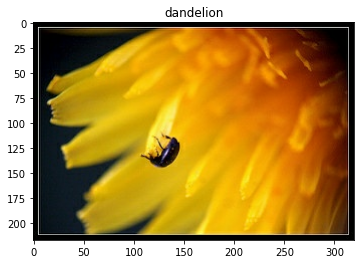

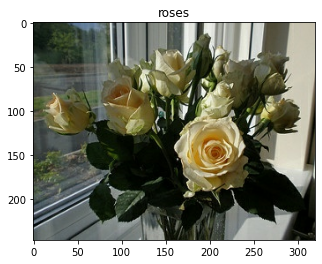

In [12]:
FILE_PATTERN = OUTPUT_DIR + "/train*"


def parse_example(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example


ds = tf.data.TFRecordDataset(tf.io.gfile.glob(FILE_PATTERN))
ds = ds.map(parse_example)

for example in ds.take(2):
    plt.imshow(example["image"].numpy())
    plt.title(CLASSES[example["label"].numpy()])
    plt.show()

Congrats! You have succesfully deployed a Dataflow pipeline to serialize an entire image dataset to TFRecords at scale.